# Panelregression med fixed effects

Analyser av [paneldata](xtset_sv.html) kan inkludera variabler som varierar mellan enheter, över tid, eller både och. När vi försöker besvara en kausal frågeställning är vi ofta mest intresserade av variationen över tid, eftersom det kan vara svårt att avgöra hur skillnader mellan enheter uppkommit, eftersom de kan vara resultatet av processer som pågått under lång tid.

Genom att jämföra enheter med sig själva, över tid, kan vi bortse från skillnaderna mellan enheterna, och komma närmare ett kontrafaktiskt ideal. Om vi vill visa att X faktiskt påverkar Y är det ett starkare bevis att visa att de hänger ihop inom enheter, inte bara mellan.

Vi kan lätt göra sådana här jämförelser med så kallade *fixed effects* i regressionsanalys. I den här guiden ska vi gå igenom både intuitionen för att förstå fixed effects, och hur man kan implementera dem i Stata. Den som bara är intresserad av själva koden kan hoppa direkt till slutet av inlägget, till avsnittet "Fixed effects med xtreg".

## Ett exempel: Kvinnligt inflytande i politiken och förnyelsebar energi.
Frågeställningen vi ska undersöka är om en högre andel kvinnor i parlamentet hänger ihop med ett bättre miljöarbete, mätt som andelen förnyelsebart i landets energiproduktion.

Vi laddar först in lite data att jobba med: QoG-institutets time-series cross-section dataset. Där har vi data om länder, över tid. För att det ska bli lite mer lättöverskådligt slänger vi bort alla länder utom två, Sverige och USA. Därefter tar vi bort alla landår där vi saknar information om andelen kvinnor i parlamentet `wdi_wip` och andelen förnyelsebar energi i energiproduktionen `wdi_elerenew`. Det gör vi med hjälp av kommandot `keep` och en [if-sats.](ifstatements_sv.html)

In [6]:
use "https://www.qogdata.pol.gu.se/dataarchive/qog_bas_ts_jan18.dta", clear
keep if cname=="Sweden" | cname=="United States"
keep if wdi_elerenew!=. & wdi_wip!=.


(Quality of Government Basic dataset 2018 - Time-Series)

(15,048 observations deleted)

(107 observations deleted)


Vi kan börja med att titta på en enkel scatterplot mellan de två variablerna. Här slänger vi bara in alla landår i analysen tillsammans, men vi märker med `mlabel(ccodealp)` också ut vilken observation som hör till vilket land. Vi kan då se att det finns ett mycket starkt samband: Landår då det var en hög andel kvinnor i parlamentet var också andelen förnyelsebart hög.

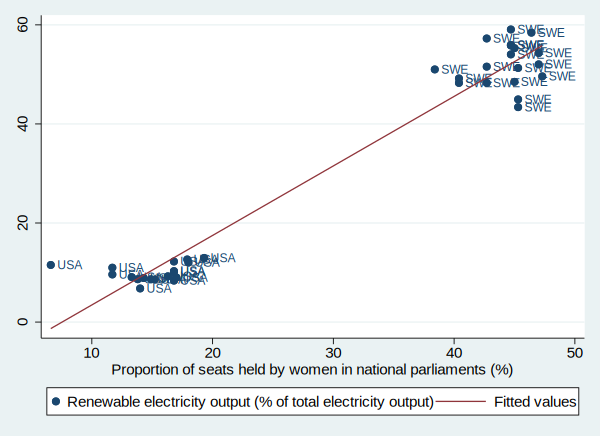

In [42]:
* Scatterplot 1: Sambandet mellan andelen kvinnor i parlamentet och andelen förnyelsebart
twoway (scatter wdi_elerenew wdi_wip, mlabel(ccodealp) mlabsize(small)) ///
       (lfit wdi_elerenew wdi_wip)

Om vi gjorde en regression på det här sambandet skulle vi se att det var starkt positivt och signifikant. Men vi ser också att alla observationer nere till vänster hör till USA, och alla uppe till höger hör till Sverige. Hur säkra kan vi då, utifrån den här analysen, vara på att produktionen av förnyelsebar energi skulle öka om vi ökade andelen kvinnor i parlamentet i endera land? Inte särskilt. Vår analys har mest visat att både andelen kvinnor och andelen förnyelsebart är högre i Sverige. Men det är ju väldigt mycket annat som skiljer Sverige och USA åt, förutom andelen kvinnor i parlamentet.

## Jämföra inom länder
Låt oss därför se hur sambandet mellan de två variablerna ser ut, inom respektive land. Vi gör om scatterploten, fast delar upp den på de två länderna med optino `by(cname)`, och så märker vi istället observationerna med år.


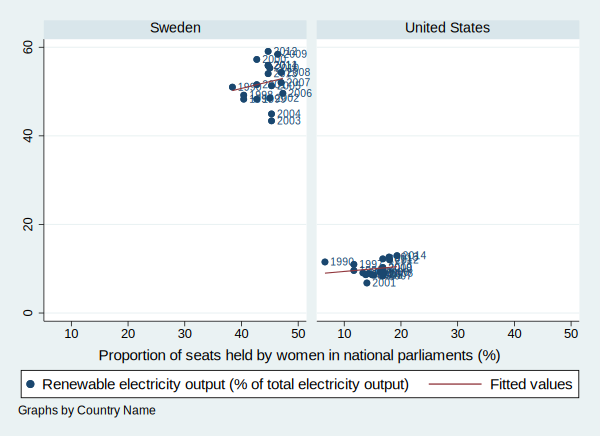

In [41]:
* Scatterplot 2: Sambandet mellan andel kvinnor i parlamentet och andelen förnyelsebart, uppdelat på land
twoway (scatter wdi_elerenew wdi_wip, mlabel(year) mlabsize(small)) ///
       (lfit wdi_elerenew wdi_wip) ///
       , by(cname)

Nu ser vi att de utritade regressionslinjerna blir mycket plattare, när de bara dras inom respektive land. Till exempel kan man se att Sverige 2003 och 2004 hade en högre andel kvinnor i riksdagen än 1990, men andelen förnyelsebart var lägre. Hypotesen att fler kvinnor i politiken leder till mer miljösatsningar ser nu mycket svagare ut.

**En analys med fixed effects gör ungefär den här typen av analys,** fast vi kommer då få ut ett enda värde på sambandet (i grafen ovan kan lutningen på regressionslinjen vara olika för varje land).

## Avvikelser kring medelvärdet
Ett sätt att få in de båda länderna i samma analys är att titta på avvikelser kring varje lands medelvärde. Istället för att se om landår med en hög andel kvinnor också hade en högre andel förnyelsebart kollar vi på om **landår då andelen kvinnor var högre än normalt för landet också hade en högre andel förnyelsebart än vad som är normalt för landet**. Det vill säga, exakt vad vi gjorde i dubbelgrafen ovan.

I koden nedan gör vi i två steg en ny variabel som visar varje lands andel förnyelsebar energi, som avvikelse kring det landets medelvärde. Den första raden räknar ut medelvärdet för varje land, och i den andra raden gör vi en variabel som visar avvikelsen från det medelvärdet. Sen gör vi samma sak för andelen kvinnor i parlamentet.

In [15]:
egen mean_energy = mean(wdi_elerenew), by(cname)
gen demeaned_energy = wdi_elerenew-mean_energy

egen mean_women = mean(wdi_wip), by(cname)
gen demeaned_women = wdi_wip-mean_women

I grafen nedan kan vi se hur andelen förnyelsebart har varierat över tid i Sverige (blå linje) och USA (röd linje), men inte i absoluta tal, utan som avvikelse från varje lands medelvärde. Sverige ligger i själva verket högre hela tiden, men nu när vi jämför varje land med sig själv så kan vi lättare få syn på gemensamma trender. Det verkar till exempel vara en uppåtgående trend sedan början av 2000-talet i båda länderna.

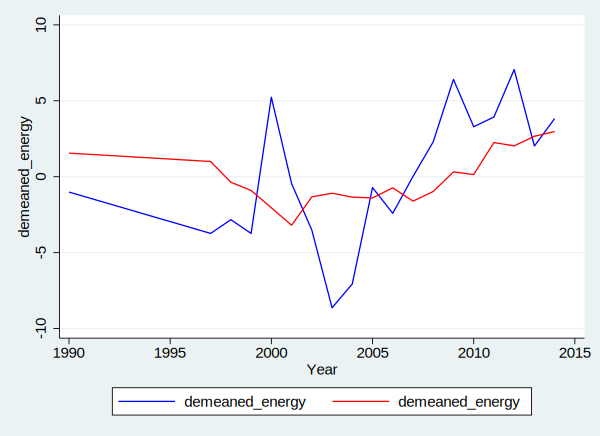

In [23]:
* Andelen förnyelsebar energi i Sverige och USA över tid, som avvikelse från respektive lands medelvärde
twoway  (line demeaned_energy year if cname=="Sweden", lcolor(blue)) ///
        (line demeaned_energy year if cname=="United States", lcolor(red))

Om vi nu tittar på sambandet mellan andelen kvinnor i parlamentet (som avvikelse från landets medelvärde) och andelen förnyelsebar energi (som avvikelse från landets medelvärde) ser grafen ut som nedan. Inget särskilt tydligt samband, i alla fall inte om vi jämför med den ursprungliga scatterploten. Nu har vi tagit bort all mellanlandsvariation, och fokuserar nu enbart på variationen inom länder, över tid. Och då finns det inte mycket till samband (vilket vi kunde se när vi jämförde länderna med sig själva, i den andra scatterploten). **Det här är vad vi avser när vi säger att vi gör en regressionsanalys med fixed effects: vi jämför enheterna med sig själva.** Men det går att göra ännu snabbare, med regressionsanalys.

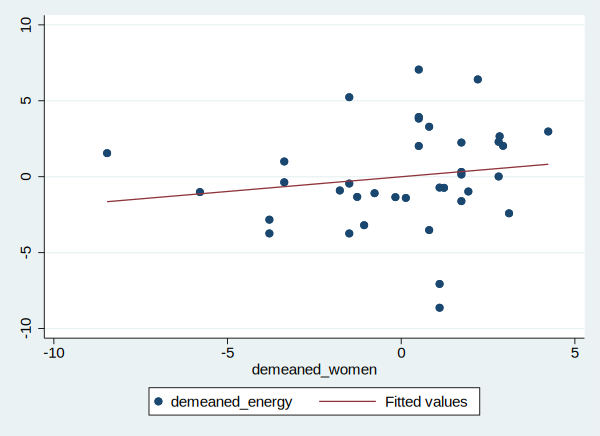

In [22]:
* Scatterplot över sambandet mellan variablerna som avvikelser från respektive lands medelvärde
twoway (scatter demeaned_energy demeaned_women) (lfit demeaned_energy demeaned_women)

## Fixed effects med dummyvariabler
I en regressionsanalys kan vi lätt lägga in variabler för att ta bort mellanlandsvariationen på samma sätt som vi gjorde i graferna ovan. Lösningen är att lägga in dummyvariabler, en för varje enhet - i det här fallet, en för varje land (förutom ett, som lämnas som referenskategori). Eftersom vi i det här exemplet bara har två länder (Sverige och USA) kommer det bara behövas en dummyvariabel.

Dummyvariablerna kommer göra precis det vi såg ovan, nämligen kontrollera bort all mellanlandsvariation, så att det enda som ligger till grund för analysen är variationen över tid. Vi kan använda prefixet `i.` för att automatiskt göra dummyvariabel av landskodsvariabeln `ccode`. Nedan gör vi två regressionsanalyser, där beroende variabel är andelen förnyelsebar energi och oberoende är andel kvinnor i parlamentet. I den andra lägger vi också in dummyvariabel för länder. Sedan presenteras båda två i en tabell med hjälp av kommandot [esttab](esttab_sv.html).

In [28]:
* Regressionsanalys med och utan dummyvariabler för land (fixed effects)
quietly reg wdi_elerenew wdi_wip
estimates store m1

quietly reg wdi_elerenew wdi_wip i.ccode
estimates store m2

esttab m1 m2







--------------------------------------------
                      (1)             (2)   
             wdi_elerenew    wdi_elerenew   
--------------------------------------------
wdi_wip             1.403***        0.194   
                  (26.77)          (0.92)   

752.ccode                               0   
                                      (.)   

840.ccode                          -36.39***
                                  (-5.83)   

_cons              -10.57***        43.44***
                  (-6.02)          (4.65)   
--------------------------------------------
N                      37              37   
--------------------------------------------
t statistics in parentheses
* p<0.05, ** p<0.01, *** p<0.001


Det intressanta här är att jämföra koefficienten för `wdi_wip`. I den första modellen är den starkt positiv och signifikant (1,403). I den andra är den mycket svagare (0,194), och inte statistiskt signifikant. Det här är skillnaden mellan den första och den tredje scatterploten. I den tredje scatterploten är lutningen på linjen just 0,194.

I princip hela sambandet mellan förnyelsebar energi och kvinnor i parlamentet berodde alltså på mellanlandsvariation, att Sverige låg mycket högre än USA.

## Fixed effects med `xtreg`

Stata har även ett regressionskommando som är specialanpassat för att göra regressionsanalyser på paneldata, `xtreg`. Det kräver att man först specifierar panelstrukturen med hjälp av `xtset`, som jag [skrivit om i ett annat inlägg](xtset_sv.html). Här anger vi att land är enhetsvariabeln, och år tidsvariabeln, genom att skriva `xtset ccode year`.

Sedan använder vi `xtreg` som vi brukar använda `reg`, men vi kan nu lägga till ett option, `fe` för fixed effects. Då lägger Stata automatiskt till dummyvariabler för alla länder i datan. De komemr dock inte visas i outputen.

In [29]:
xtset ccode year
xtreg wdi_elerenew wdi_wip, fe


       panel variable:  ccode (unbalanced)
        time variable:  year, 1990 to 2014, but with gaps
                delta:  1 unit


Fixed-effects (within) regression               Number of obs     =         37
Group variable: ccode                           Number of groups  =          2

R-sq:                                           Obs per group:
     within  = 0.0243                                         min =         18
     between = 1.0000                                         avg =       18.5
     overall = 0.9534                                         max =         19

                                                F(1,34)           =       0.85
corr(u_i, Xb)  = 0.9839                         Prob > F          =     0.3639

------------------------------------------------------------------------------
wdi_elerenew |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     wdi_

Outputen är snarlik den vi får från en vanlig regressionsanalys, men vi får även lite specialinfo som har att göra med panelstrukturen. Vi kan till exempel uppe till höger se att det är 37 observationer, fördelade på två grupper (länder). Nedan står det beskrivande information om hur många observationer det är per grupp. Till vänster under rubriken r-sq ser vi hur mycket av variationen i datan som förklarats av modellen. R-sq within syftar på hur mycket av variationen inom länder som förklarats: inte särskilt mycket. Däremot förklaras i princip all mellanlandsvariation, men det är inte den vi är intresserad av.

Koefficienten för kvinnor i parlamentet är precis som i den tidigare regressionsanalysen (när vi själva la in dummyvariabler) 0,194 och inte signifikant. De två sätten att göra analysen är likvärdiga.

Det enda som skiljer är interceptet (konstanten). När vi lägger in egna dummyvariabler visar siffran i tabellen interceptet för referenslandet. Med `xtreg`-kommandot blir det istället ett genomsnittsintercept för alla land. Inget av dem är särskilt intressant och lämnas ofta ute ur redovisningen.

## Fixed effects gör att vi inte kan ha med variabler som inte varierar över tid
Fixed effects "äter upp" all variation mellan länder, vilket betyder att vi inte kan ha med variabler i analysen som inte varierar över tid. Geografiskt läge skiljer sig till exempel mellan Sverige och USA, men varierar inte över tid. Därför har den variabeln inget att tillföra utöver dummyvariablerna för land. Om man försöker ha med en sådan variabel kommer Stata slänga ut den och bara skriva "xyz omitted because of collinearity".

In [40]:
xtreg wdi_elerenew wdi_wip, fe


Fixed-effects (within) regression               Number of obs     =         37
Group variable: ccode                           Number of groups  =          2

R-sq:                                           Obs per group:
     within  = 0.0243                                         min =         18
     between = 1.0000                                         avg =       18.5
     overall = 0.9534                                         max =         19

                                                F(1,34)           =       0.85
corr(u_i, Xb)  = 0.9839                         Prob > F          =     0.3639

------------------------------------------------------------------------------
wdi_elerenew |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     wdi_wip |   .1939546   .2107536     0.92   0.364    -.2343482    .6222574
       _cons |    25.7381   6.352159     4.05   0.000     12.828

## Nackdelar med fixed effects
Fixed effects är ett enkelt och snabbt sätt att kontrollera bort en massa potentiellt störande variation för att fokusera på variation inom enheter. Nackdelen är att det inte är särskilt teoretiskt. Skillnaderna mellan Sverige och USA beror ju på någonting, men det kan vi inte säga någonting om här. Och man skulle i princip kunna tänka sig att anledningen till att Sverige har en så hög andel förnyelsebart är att vi under lång tid haft många kvinnor i parlamentet, även om vi inte kan se skillnader från år till år. Om så är fallet kommer vår analys med fixed effects att underskatta den sanna effekten av kvinnor i parlamentet.

Det gäller därför, som vanligt att veta vad det är man är ute efter när man gör sin analys. Fixed effects är bra när man vill ta bort variation mellan enheter, och fokusera på förändringar över tid, inom vavrje enhet. Det är ofta bra när man vill har kausala anspråk, men inte alltid.